In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from graphviz import Digraph
from graphviz import Source

In [85]:
data = pd.read_csv("PercentageIncreaseCOVIDWorldwide.csv")
data = data.drop(0,0)
data = data.reset_index(drop = True)
for i in range(0,len(data)):
    data['Date'][i] = i

<ipython-input-85-2b5163a223d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'][i] = i


In [86]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [87]:
def train_val_test(df,test_size):
    temp,test = train_test_split(df, test_size)
    train,val = train_test_split(temp, test_size)
    
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    val = val.reset_index(drop=True)
    return train,val,test

In [88]:
def find_rmse(y_pred,y_test):
    return np.sqrt((np.subtract(y_pred, y_test) ** 2).sum()/len(y_test))

def find_r2(y_pred,y_test):
    num = 0
    deno = 0
    for i in range (0,len(y_pred)):
        num = num + (y_pred[i]-y_test[i])**2
        deno = deno + (y_test[i]-y_test.mean())**2
    
    return 1-(num/deno)

In [89]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
def create_leaf(data):
    
    label_column = data[:, -1]
    leaf = np.mean(label_column)
    
    return leaf


def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

def calculate_var(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   
        prediction = 0
        
    else:
        prediction = np.var(actual_values)
    
    return prediction


def calculate_overall_metric(data,data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n
        
    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    overall_metric = metric_function(data)-overall_metric
    
    return overall_metric


def determine_best_split(data, potential_splits):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            current_overall_metric = calculate_overall_metric(data,data_below, data_above, metric_function=calculate_var)
            
            if first_iteration or current_overall_metric >= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "c":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
       
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]
            feature_types.append("c")
    
    return feature_types


def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5,):
    
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data)
        return leaf

    
    else:    
        counter += 1

        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data)
            return leaf
        
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "c":
            question = "{} <= {}".format(feature_name, split_value)
        
        sub_tree = {question: []}
        
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
                
        return sub_tree


def predict_example(example, tree):
    
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]


    if not isinstance(answer, dict):
        return answer
    
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
       
        predictions = 0
        
    return predictions


def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.label
    accuracy = predictions_correct.mean()
    
    return accuracy

In [90]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    return df_yes, df_no

def determine_leaf(df_train):
    return df_train['Increase rate'].mean()

def determine_errors(df_val, tree):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val['Increase rate']
    
    return ((predictions - actual_values) **2).mean()

def pruning_result(tree, df_train, df_val):
    
    leaf = determine_leaf(df_train)
    errors_leaf = determine_errors(df_val, leaf)
    errors_decision_node = determine_errors(df_val, tree)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

def post_pruning(tree, df_train, df_val):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val)
        
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val)

In [91]:
def find_depth(tree):
    if not isinstance(tree,dict):
        return 0
    
    question = list(tree.keys())[0]
    left,right = tree[question]
    
    ldepth = find_depth(left)
    rdepth = find_depth(right)
    
    if ldepth>rdepth:
        return ldepth+1
    else:
        return rdepth+1

In [92]:

def part1(data):
    inp = int(input("Enter Depth "))
    max_acc=float('-inf')
    avg=0
    for i in range(0,10):
        random.seed(i+9)
        df_train,df_val,df_test = train_val_test(data, 0.2)
        tree = decision_tree_algorithm(df_train,max_depth=inp)
        y_pred = make_predictions(df_test,tree)
        y_test = df_test['Increase rate']
        acc = find_r2(y_pred,y_test)
        avg = avg+acc
        if max_acc<acc:
            max_acc = acc
            best_train_data = df_train
            best_test_data = df_test
            best_valid_data = df_val

    print(avg/10)
    print(max_acc)
    
    return inp , best_train_data,best_valid_data,best_test_data
        

In [93]:
inp , best_train,best_val,best_test = part1(data)


Enter Depth 10
0.5426520229681893
0.9440645057284467


In [94]:
def part2(best_train,best_val,best_test):
    train_predictions = []
    test_predictions = []
    x_axis = []
    best_test_acc = float('-inf')
    best_height = 0
    for i in range(1,10):
        x_axis.append(i*2)
        trees = decision_tree_algorithm(best_train, max_depth=i*2)
        y_predictions =  make_predictions(best_test,trees)
        y_train_predictions = make_predictions(best_train,trees)
        train_predictions.append(find_r2(y_train_predictions,best_train['Increase rate']))
        test_predictions.append(find_r2(y_predictions,best_test['Increase rate']))
        if find_r2(y_predictions,best_test['Increase rate'])>best_test_acc:
            best_test_acc = find_r2(y_predictions,best_test['Increase rate'])
            best_height = i*2
        
    return x_axis,train_predictions,test_predictions,best_height

In [95]:
x_axis,train_acc,test_acc,best_height = part2(best_train,best_val,best_test)

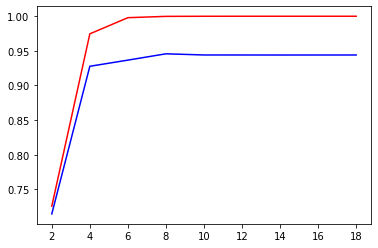

Optimal height obtained is :
8


In [96]:
plt.plot(x_axis,train_acc,'r')
plt.plot(x_axis,test_acc,'b')
plt.show()
print("Optimal height obtained is :")
print(best_height)

In [97]:
best_tree =  decision_tree_algorithm(best_train, max_depth=best_height)
y_best_pred =  make_predictions(best_test,best_tree)
find_r2(y_best_pred,best_test['Increase rate'])

0.9457466937998278

In [98]:
best_pruned_tree = post_pruning(best_tree,best_train,best_val)
y_prune = make_predictions(best_test,best_pruned_tree)
find_r2(y_prune,best_test['Increase rate'])

0.9429467211037178

In [99]:
print("Depth of the tree is : ")
print(find_depth(best_pruned_tree))


Depth of the tree is : 
8


In [100]:
grp = Digraph()

def store_tree(tree,idx=0):
    
    question = list(tree.keys())[0]
    if idx==0:
        grp.node(str(idx),question)
        
    left,right = tree[question]
    
    if not isinstance(left,dict):
        grp.node(str(2*idx+1),str(left))
        grp.edge(str(idx),str(2*idx+1),"True")
        
        
    else:
        lft_attr = list(left.keys())[0]
        grp.node(str(2*idx+1),lft_attr)
        grp.edge(str(idx),str(2*idx+1),"True")
        store_tree(left,2*idx+1)
        
    if not isinstance(right,dict):
        grp.node(str(2*idx+2),str(right))
        grp.edge(str(idx),str(2*idx+2),"False")
        
    else:
        rgt_attr = list(right.keys())[0]
        grp.node(str(2*idx+2),rgt_attr)
        grp.edge(str(idx),str(2*idx+2),"False")
        store_tree(right,2*idx+2)

In [101]:
store_tree(best_tree)
grp.view()

'Digraph.gv.pdf'